In [ ]:
import test as t

t.helloWorld()


In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
from os import getcwd
from zipfile import ZipFile
from time import sleep

print (getcwd())

C:\Users\Owner\Documents\git\mfnn


In [2]:
def get_filename (path):
    return path.split('/')[-1]

def retrieve (url, dest_dir='.', desc='', overwrite=False):

    def pbar_updater (block_num, block_size, total_size):
        '''ref: https://github.com/tqdm/tqdm#hooks-and-callbacks'''
        if pbar.total != total_size:
            pbar.total = total_size
        pbar.update(block_num * block_size - pbar.n)
        '''pbar.n is the current total of bytes downloaded'''
        return

    filename = get_filename(url)
    destination = dest_dir + "/" + filename
    if not isfile(destination) or overwrite:
        with tqdm (unit='B', unit_scale=True, miniters=1) as pbar:
            if desc == '': 
                desc = filename
            pbar.set_description(desc)
            urlretrieve(url, destination, pbar_updater)
            pbar.refresh()
    return destination

def unzip(source_filename, dest_dir):
    '''ref: https://docs.python.org/2/library/zipfile.html#zipfile.ZipFile.extract'''
    with ZipFile(source_filename) as zf:
        zf.extractall(dest_dir)        
    return

url_bike_sharing_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
data_dir              = 'data'
file_name = retrieve(url       = url_bike_sharing_data,
                     dest_dir  = data_dir,
                     overwrite = True)

unzip (file_name, data_dir)

Bike-Sharing-Dataset.zip: 287KB [00:01, 283KB/s]                                                                                                                  


In [3]:
import pandas as pd

bike_share_hour_filename = data_dir + '/hour.csv'
df_bike_share_raw = pd.read_csv (bike_share_hour_filename)
'''
df_hours format:
- each row is one hour of data for bike sharing
- primary key: instant
- other primary keys: dte_day + hr
'''


print (df_bike_share_raw.head())
print (df_bike_share_raw.max())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
instant            17379
dteday        2012-12-31
season                 4
yr                     1

In [4]:
def create_ohe_fields(df_bike_share_data, 
               categorical_fields=['season', 'weathersit', 'mnth', 'hr', 'weekday', 'holiday']):

    #--- one hot encode categorical variables
    #--- TODO: explain design decision in documents (i.e. which categorical fields, why ohe?)
    for f in categorical_fields:
        dummies = pd.get_dummies(df_bike_share_data[f], prefix=f, drop_first=False)
        bike_share_data = pd.concat([df_bike_share_data, dummies], axis=1)
        
    #--- TODO: change axis to AX_COLUMNS
    df_bike_share_data = df_bike_share_data.drop(categorical_fields, axis=1)
        
    return df_bike_share_data
        
    
def trim_unused_fields(df_bike_share_data,
                         unused_fields=['instant', 'dteday', 'atemp', 'workingday', 'yr']):
    #--- drop fields that network will not use
    #--- TODO: explain design decision (i.e. which fields and why)
    df_bike_share_data = df_bike_share_data.drop(unused_fields, axis=1)
    
    return df_bike_share_data

df_bike_share_ohe = create_ohe_fields(df_bike_share_raw)
df_bike_share_trimmed = trim_unused_fields(df_bike_share_ohe)
df_bike_share_ohe.head()    


,instant,dteday,yr,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,0,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,0,0,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,0,0,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,0,0,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,0,0,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
print(df_bike_share_trimmed.loc[0, 'temp'])

0.24


In [5]:
def rescale_to_z_scores(df_bike_share_data):
    
    #--- note: DO NOT CALL more than once

    #--- refactor continuous varibales to a z-score
    #--- z[i] = (x[i] - x_mean) / x_std_dev
    continuous_fields = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

    #--- use a dictionary to store mean and std_dev for each field
    z_factors = {}

    for field in continuous_fields:
        df_column = df_bike_share_data[field]
        mean      = df_column.mean()
        std       = df_column.std()
        z_field = 'z' + field
        
        df_bike_share_data[z_field] = (df_bike_share_data[field] - mean) / std
        
        z_factors[field] = (mean, std)
    
    return df_bike_share_data, z_factors

df_bike_share_z_scored, z_factors = rescale_to_z_scores(df_bike_share_trimmed)
print(df_bike_share_z_scored)
print(z_factors['cnt'])

       temp   hum  windspeed  casual  registered  cnt   zcasual  zregistered  \
0      0.24  0.81     0.0000       3          13   16 -0.662736    -0.930162   
1      0.22  0.80     0.0000       8          32   40 -0.561326    -0.804632   
2      0.22  0.80     0.0000       5          27   32 -0.622172    -0.837666   
3      0.24  0.75     0.0000       3          10   13 -0.662736    -0.949983   
4      0.24  0.75     0.0000       0           1    1 -0.723582    -1.009445   
5      0.24  0.75     0.0896       0           1    1 -0.723582    -1.009445   
6      0.22  0.80     0.0000       2           0    2 -0.683018    -1.016052   
7      0.20  0.86     0.0000       1           2    3 -0.703300    -1.002838   
8      0.24  0.75     0.0000       1           7    8 -0.703300    -0.969804   
9      0.32  0.76     0.0000       8           6   14 -0.561326    -0.976411   
10     0.38  0.76     0.2537      12          24   36 -0.480199    -0.857487   
11     0.36  0.81     0.2836      26    

In [6]:
import pandas as pd

class BikeShareData:
    
    def __init__(self,
                 url     = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip',
                 data_dir='data',
                 filename_hour_data = 'hour.csv'):
        
        self.url                = url
        self.data_dir           = data_dir
        self.filename_hour_data = filename_hour_data
        self.df_bike_share_data = None   #--- pandas dataframe to store bike sharing data
        
        self.categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'holiday']
        self.unused_cols      = ['instant', 'dteday', 'atemp', 'workingday', 'yr']
        self.continuous_cols  = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
        self.z_factors        = {}
        self.target_cols      = ['cnt']

        self.ax_column        = 1 #--- constant for axis number of columns in dataframe
        
        self.days_for_test_data       = 21    
        self.days_for_validation_data = 60

        return
    
    def retrieve(self):
        
        file_name = retrieve(url=self.url, dest_dir=self.data_dir)
        unzip(file_name, self.data_dir)
        
        #--- create the pandas data frame for the bike share data from the unzip .csv file
        self.df_bike_share_data = pd.read_csv(self.data_dir + '/' + self.filename_hour_data)
        
        return
    
    def preprocess(self):
        
        self._create_ohe_cols()
        self._drop_unused_cols()
        self._rescale_cont_cols()
        
        return
    
    
    def create_data_sets(self):
        
        training_set, validation_set = self._create_training_set()
        testing_set                  = self._create_testing_set()

        return training_set, validation_set, testing_set
    
    
    def _create_ohe_cols(self):

        #--- one hot encode (ohe) categorical values
        #--- TODO: explain design decision in documents (i.e. which categorical fields, why ohe?)
        for col in self.categorical_cols:
            dummies = pd.get_dummies(self.df_bike_share_data[col], prefix=col, drop_first=False)
            self.df_bike_share_data = pd.concat([self.df_bike_share_data, dummies], axis=self.ax_column)

        #--- remove the categorical columns since they are now one-hot-encoded
        #--- TODO: change axis to AX_COLUMNS
        self.df_bike_share_data = self.df_bike_share_data.drop(self.categorical_cols, axis=self.ax_column)

        return 

    def _drop_unused_cols(self):
        #--- drop columns that network will not use
        #--- TODO: explain design decision (i.e. which fields and why)
        #--- TODO: change axis to AX_COLUMNS

        self.df_bike_share_data = self.df_bike_share_data.drop(self.unused_cols, axis=self.ax_column)

        return
    
    
    def _rescale_cont_cols(self):

        #--- calling more than once
        #--- rescale continuous values to a z-score: z[i] = (x[i] - x_mean) / x_std_dev
        #--- use the z_factors dictionary to store mean and std_dev for each col
        
        for col in self.continuous_cols:
            mean    = self.df_bike_share_data[col].mean()
            std_dev = self.df_bike_share_data[col].std()
            
            self.df_bike_share_data[col] = (self.df_bike_share_data[col] - mean) / std_dev
            self.z_factors[col]          = (mean, std_dev)

        return
    
    
    def _create_training_set(self):
        
        #--- keep ALL UP TO the last n days [:-n*24] of data for training the network
        df_training_data = self.df_bike_share_data[:-self.days_for_test_data * 24]
        
        #--- split training data into features and targets
        df_features   = df_training_data.drop(self.target_cols, axis=self.ax_column)
        df_targets    = df_training_data[self.target_cols]
        
        #--- split features and targets into sets used for training and validation of the training
        idx_validation_data_split = self.days_for_validation_data * 24    
        
        #--- keep ALL UP TO the last n days [:-n] of features and targets for training data 
        df_training_features   = df_features[:-idx_validation_data_split]
        df_training_targets    = df_targets[:-idx_validation_data_split]
        
        #--- keep THE LAST n days [-n:] for validation (during training)
        df_validation_features = df_features[-idx_validation_data_split:]
        df_validation_targets  = df_targets[-idx_validation_data_split:]

        #--- create the training and validation sets as tuples of their respective features and targets
        training_set           = (df_training_features, df_training_targets)
        validation_set         = (df_validation_features, df_validation_targets)
        
        return training_set, validation_set
    
    
    def _create_testing_set(self):
        
        #--- keep THE LAST n days [-n*24:] of data for testing the neural network
        df_testing_data = self.df_bike_share_data[-self.days_for_test_data * 24:]
        
        #--- split testing data into features and targets
        df_test_features = df_testing_data.drop(self.target_cols, axis=self.ax_column)
        df_test_targets  = df_testing_data[self.target_cols]
        
        #--- create the test set as tuples of the test features and test targets
        testing_set = (df_test_features, df_test_targets)
        
        return testing_set
        
    

data = BikeShareData()
data.retrieve()
data.preprocess()

training, validation, test = data.create_data_sets()


(15435, 1, 58) (1440, 1, 58)
(15435, 1, 58) (15435, 1, 1)
Dense: (58, 32)
Sigmoid Activation: (32, 32)
Dense: (32, 1)
Activation(Default Linear): (1, 1)


(-0.064660072628587195, 0.5)

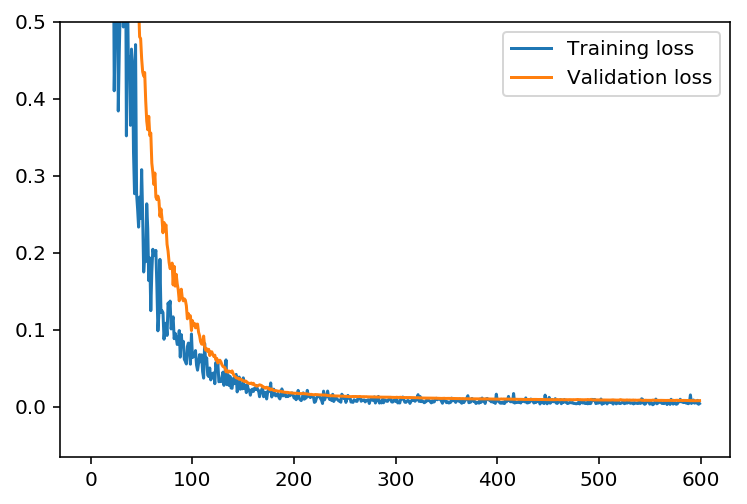

In [40]:
import numpy as np
from time import sleep   # TODO: Delete after debug

class NeuralNetwork():
    
    def __init__(self):
        
        self.layers = []
        self.training_batches = []
        self.lowest_loss = float('Inf')
        return
    
    def add(self, layer):
        self.layers.append (layer)
        return
    
    def compile(self):
        prev_layer = None
        for layer in self.layers:
            layer.compile(prev_layer)
            prev_layer = layer
        return
    
    def summary(self):
        for layer in self.layers:
            layer.summary()
        
    def update_outputs(self, inputs):

        #--- one forward pass
        #--- update first hidden layer [0]
        self.layers[0].update_outputs(inputs)
        
        #--- update all remaining layers [1:]
        prev_layer = self.layers[0]
        for layer in self.layers[1:]:
            layer.update_outputs(prev_layer.outputs)
            prev_layer = layer
        return 
    
    def update_errors(self, labels):

        #--- back propagate output errors
        #--- output layer is last layer [-1]
        output_error = np.array(labels - self.layers[-1].outputs, ndmin=2)
        self.layers[-1].update_errors(output_error)
        
        #--- backpropagate error by iterating the reversed order of layers
        prev_layer = self.layers[-1]
        for layer in (self.layers[::-1])[1:]:
            layer.update_errors(prev_layer.errors)
            prev_layer = layer
        return

    def update_weights(self, learning_rate, batch_size):
        for layer in self.layers:
            layer.update_weights(learning_rate, batch_size)
        return
    
    
    def _init_training_batches(self, inputs, targets, batch_size):
        num_samples = len(inputs)
        self.training_batches=[]
        
        for start in range(0, num_samples, batch_size):
            end            = min (start + batch_size, num_samples)
            features       = inputs[start:end]
            labels         = targets[start:end]
            training_batch = (features, targets)
            self.training_batches.append(training_batch)
        return 
    
    def create_random_batch(self, inputs, targets, batch_size=32):
        
        indices = np.random.choice(len(inputs), size=batch_size)
        
        return inputs[indices], targets[indices]
    
    
    def _init_weight_steps(self):
        for layer in self.layers:
            layer.init_weight_steps()
    
    
    def predict_on_batch(self, batch_features):
        batch_predictions = np.array([])
        for features in batch_features:
            self.update_outputs(features)
            batch_predictions = np.append(batch_predictions, self.layers[-1].outputs)
        return batch_predictions
    
    
    def test_on_batch(self, batch_features, batch_labels):
        batch_predictions = self.predict_on_batch(batch_features)
        sq_errors = [(labels - predictions) ** 2 for labels, predictions in zip(batch_labels, batch_predictions)]
        loss = np.mean(sq_errors)
        return loss
    
    
    def train_on_batch(self, batch_features, batch_labels, learning_rate):
        
        #--- len (batch_features) == len (batch_labels)
        self._init_weight_steps()
        
        #--- process each row of features and labels in batch
        for features, labels in zip(batch_features, batch_labels):
            self.update_outputs(features)
            self.update_errors(labels)
            
        #--- all rows processed; update weights and evaluate model
        self.update_weights(learning_rate, batch_size=len(batch_features))
        batch_loss = self.test_on_batch(batch_features, batch_labels)
        
        return batch_loss
        
    
    #--- 
    def fit (self, inputs, targets, epochs, learning_rate, batch_size, verbose=1, validation_data=None):
        '''
        inputs:  numpy array of shape (num_inputs, num_features)
        targets: numpy array of shape (num_inputs, num_labels) i.e. target.shape[0] == inputs.shape[0]
        '''
        
        losses = []
        validate = validation_data is not None
        
        if validate:
            #--- unpack validation data
            validation_inputs, validation_targets = validation_data
            validation_losses = []
            
        for e in range(epochs):
            #--- process epoch e
            
            #--- 15nov17: we needed to select a random sample to prevent overfitting
            batch_features, batch_labels = self.create_random_batch(inputs, targets, batch_size)
            batch_loss     = self.train_on_batch(batch_features, batch_labels, learning_rate)
            
            losses.append(batch_loss)
            
            if validate:
                validation_loss = self.test_on_batch(validation_inputs, validation_targets)
                validation_losses.append(validation_loss)
            
            if (verbose != 0):
                if validate:
                    status = "Epoch " + str(e + 1) + " of " + str (epochs) + " - Loss:" + str(batch_loss) \
                        + " - Validation Loss:" + str(validation_loss) + " - Batch size : " + str(batch_size)
                else:
                    status = "Epoch " + str(e + 1) + " of " + str (epochs) + " - Loss:" + str(batch_loss) \
                        + " - Batch size : " + str(batch_size)
                print (status, end="\r")
                sleep(0.0005)
                
        return losses, validation_losses
    

class Layer():
    
    def __init__(self):
        self.input_size = None
        self.output_size = None
        self.outputs = None
        self.errors = None
        self.name = "Layer"
        return
        
    def compile(self, prev_layer):
        self.input_size = prev_layer.output_size
        self.output_size = self.input_size
        return
    
    def update_outputs(self, inputs):
        self.outputs = inputs
        return
    
    def update_errors(self, errors):
        self.errors = errors
        return
    
    def update_weights(self, learning_rate, batch_size):
        pass
    
    def init_weight_steps(self):
        pass
    
    def summary(self):
        print (self.name + ":", (self.input_size, self.output_size))
        
            

class Activation(Layer):
    '''default activation layer is a linear activation'''
    
    def __init__(self):
        Layer.__init__(self)
        self.name = "Activation(Default Linear)"
        return
    
    def compile(self, prev_layer):
        self.input_size = prev_layer.output_size
        self.output_size = self.input_size
        
        return
    
    def f(self, x):
        #override f in descendants
        #linear activation is f(x) = x
        return x
    
    def dfdx(self):
        # override dfdx (derivative of f(x) wrt x) in descendents
        # derivative of f(x) is f'(x) = 1 
        # dfdx() is used in the call to update_errors
        return 1
    
    def update_outputs(self, x):
        # linear activation 
        self.outputs = self.f(x)
        return
    
    def update_errors(self, errors):
        self.errors = errors * self.dfdx()
        return
    
    def update_weights(self, learning_rate, batch_size):
        # activation layers have no weights to update
        pass
        
    
    
class Sigmoid(Activation):
    
    def __init__(self):
        Activation.__init__(self)
        self.name = "Sigmoid Activation"
        return
    
    def f(self, x):
        # f(x) = 1 / (1 + exp(x))
        return 1.0 / (1.0 + np.exp(-x))
    
    def dfdx(self):
        # for sigmoid function, f'(x) = f(x) * (1 - f(x))
        return self.outputs * (1 - self.outputs)
    

#--- TODO: fix leaky rectified linear unit activation
class LRelu(Activation):
    #--- DON't USE YET
    
    def __init__(self):
        Activation.__init__(self)
        self.name = "Leaky ReLU"
        self.threshold = 0.01
        self.lrelu_val = None
        self.lrelu_grad_val = None
        return
    
    def f(self, x):
        #--- x.shape (1, num_outputs)
        if self.lrelu_val is None:
            self.lrelu_val = np.empty_like(x)
        self.lrelu_val[0] = [max (a, self.threshold) for a in x[0]]
        return self.lrelu_val
    
    def dfdx(self):
        #--- self.outputs is a vector
        #--- self.outputs.shape is (1, num_ouputs)
        if self.lrelu_grad_val is None:
            self.lrelu_grad_val = np.empty_like(self.outputs)
        self.lrelu_grad_val[0] = [1 if a > self.threshold else self.threshold for a in self.outputs[0]]
        return self.lrelu_grad_val
            
    
            
class Dense(Layer):
    
    def __init__(self, output_size, input_size=None, weights=None):

        Layer.__init__(self)
        self.mean = 0.0
        self.std_dev = 0.1
        self.weights = weights
        self.biases = None
        self.output_size = output_size
        self.input_size = input_size
        self.name = "Dense"
        self.batch_size = 1

        return
    
        
    def _init_weights(self, input_size):
        
        if self.weights is None:
            shape_weights = (input_size, self.output_size)
            self.weights = np.random.normal(self.mean, self.std_dev, shape_weights)
            self.biases  = np.random.normal(self.mean, self.std_dev, self.output_size)
            
        return
    
    def compile(self, prev_layer):

        if prev_layer is not None:
            self.input_size = prev_layer.output_size
        self._init_weights(self.input_size)
        return

        
    def update_outputs(self, x):
        
        # x.shape should be (1, input_size)
        # shape of weights is (input_size, output_size)
        # self.outputs = np.dot(x, self.weights) + self.biases
        # shape of outputs is (1, output_size)        
        # we save x (the layer inputs) to self.inputs...
        # ... because it will be used to update delta_w in update_errors()
        self.inputs = x    
        self.outputs = np.dot(self.inputs, self.weights) 
        return 

        
    def update_errors(self, errors):
        # self.error back propagated to update prev layer
        self.delta_w += errors * self.inputs.T
        self.errors = np.dot (errors, self.weights.T)

        return
    
    def init_weight_steps(self):
        self.delta_w = np.zeros(self.weights.shape)
        return
    
    def update_weights(self, learning_rate, sample_size):
        self.weights += learning_rate * self.delta_w / sample_size
        return
    
def pddf_to_nparr(pddf):

    rows = np.array(pddf, ndmin=2)
    arr = [np.array(row, ndmin=2) for row in rows]
    return np.array(arr, ndmin=2)
    
        
'''
features = np.array([0.5, 0.1, -0.2], ndmin=2)
weights_1 = np.array([[0.5, -0.6], [0.1, -0.2], [0.1, 0.7]])
weights_2 = np.array([[0.1], [-0.3]])
labels = np.array([0.6], ndmin=2)
'''

inputs  = pddf_to_nparr(training[0])
targets = pddf_to_nparr(training[1])

validation_inputs = pddf_to_nparr(validation[0])
validation_targets = pddf_to_nparr(validation[1])
validation_data = (validation_inputs, validation_targets)

print (inputs.shape, validation_inputs.shape)

print (inputs.shape, targets.shape)

neural_net = NeuralNetwork()
neural_net.add(Dense(32, input_size=inputs.shape[2]))
neural_net.add(Sigmoid())


neural_net.add(Dense(1))
neural_net.add(Activation())

neural_net.compile()
neural_net.summary()
loss_history, validation_loss_history = neural_net.fit(inputs, targets, 
                              learning_rate=0.1, epochs=600, batch_size=128, 
                              validation_data=validation_data)
        
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    
plt.plot(loss_history, label='Training loss')
plt.plot(validation_loss_history, label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)        


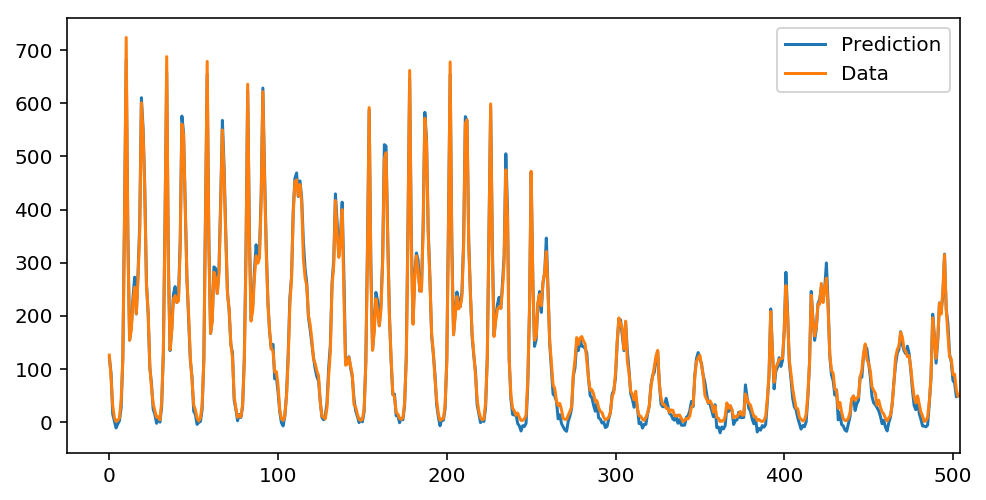

In [49]:
fig, ax = plt.subplots(figsize=(8,4))

test_inputs  = pddf_to_nparr(test[0])
test_targets = pddf_to_nparr(test[1])

mean, std = data.z_factors['cnt']
predictions = neural_net.predict_on_batch(test_inputs)*std + mean

ax.plot(predictions, label='Prediction')
ax.plot(np.squeeze(test_targets)*std + mean, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

In [76]:
a = []
for i in a:
    print (i)

In [ ]:
a = [1, 2, 3, 4]
print (a[::-1])

In [ ]:
import numpy as np

input_size = 3
layer_size = 4
mean = 0.0
std_dev = 0.5
shape_weights = (input_size, layer_size)
weights = np.random.normal(mean, std_dev, shape_weights)
print (weights)

In [ ]:
print (training[0].head())
print (training[1].head())

In [ ]:
a = pd.Series([1, 2])
b = pd.Series([3, 4])
c = pd.concat([a, b])
print (c)
print (a)

In [ ]:
import numpy as np

df = pd.DataFrame(np.arange(12).reshape(3,4),
                      columns=['A', 'B', 'C', 'D'])

def foo (df):
    col = df['A']
    col = col - 1
    df ['A'] = col
    


In [ ]:
foo (df)
print (df)
print (df.loc[:, 'A':'D'])
print (df.loc[:, 'A'])
print (df.loc[:, 'A'])

In [ ]:
i = np.array([0.5, 0.1, -0.2], ndmin=2)
print (i.shape, i)
w = np.array([[0.5, -0.6], [0.1, -0.2], [0.1, 0.7]])
out = np.dot(i, w)
print (out.T.shape, out.T)
0.00160809  * 0.5
0.00333551 * 0.5

In [ ]:
def f():
    pass

def a():
    print ('a')
    f()
    return

a()

In [69]:
test = (1, 2)
a, b = test
print (b)

2


In [25]:
x = np.arange(10,1,-1)
x
x[np.array([3, 3, 2, 0])]

array([ 7,  7,  8, 10])